
# Receiver Operating Characteristic (ROC) with cross validation

This example presents how to estimate and visualize the variance of the Receiver
Operating Characteristic (ROC) metric using cross-validation.

ROC curves typically feature true positive rate (TPR) on the Y axis, and false
positive rate (FPR) on the X axis. This means that the top left corner of the
plot is the "ideal" point - a FPR of zero, and a TPR of one. This is not very
realistic, but it does mean that a larger Area Under the Curve (AUC) is usually
better. The "steepness" of ROC curves is also important, since it is ideal to
maximize the TPR while minimizing the FPR.

This example shows the ROC response of different datasets, created from K-fold
cross-validation. Taking all of these curves, it is possible to calculate the
mean AUC, and see the variance of the curve when the
training set is split into different subsets. This roughly shows how the
classifier output is affected by changes in the training data, and how different
the splits generated by K-fold cross-validation are from one another.

<div class="alert alert-info"><h4>Note</h4><p>See `sphx_glr_auto_examples_model_selection_plot_roc.py` for a
    complement of the present example explaining the averaging strategies to
    generalize the metrics for multiclass classifiers.</p></div>


## Load and prepare data

We import the `iris_dataset` which contains 3 classes, each one
corresponding to a type of iris plant. One class is linearly separable from
the other 2; the latter are **not** linearly separable from each other.

In the following we binarize the dataset by dropping the "virginica" class
(`class_id=2`). This means that the "versicolor" class (`class_id=1`) is
regarded as the positive class and "setosa" as the negative class
(`class_id=0`).



In [1]:
import numpy as np

from sklearn.datasets import load_iris

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

We also add noisy features to make the problem harder.



In [2]:
random_state = np.random.RandomState(0)
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

### Classification and ROC analysis

Here we run a :class:`~sklearn.svm.SVC` classifier with cross-validation and
plot the ROC curves fold-wise. Notice that the baseline to define the chance
level (dashed ROC curve) is a classifier that would always predict the most
frequent class.



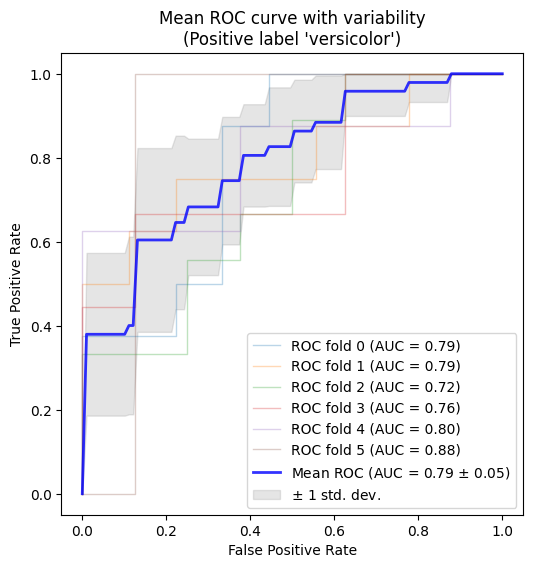

In [4]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
       
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()